# Numerical results for RTS-96

In [1]:
####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton.jl")
include("../src/TemporalInstanton2.jl")

using TemporalInstanton,TemporalInstanton2

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 0.5 # Heating constant
G0 = [Gp,Gp,Gp]
D0 = [Dp,Dp,Dp]
P0 = [0.5.*Rp,Rp,1.5*Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 0.1 # RHS of line temperature constraint
kQtheta = -c # Move to LHS so we have Q(z) = 0
lines = [(f[i],t[i]) for i in 1:length(f)];

n = size(Y,1)
nr = length(Ridx)
T = int(length(G0)/n) # infer number of time steps

# Create Qobj:
Qobj = tmp_inst_Qobj(n,nr,T)
# Augment Qobj with additional rows and columns of zeros:
Qobj = tmp_inst_pad_Q(full(Qobj),T)

# Create A1 (only A2 changes during opt.):
A1 = full(tmp_inst_A(Ridx,T,Y,ref,k))
A1 = [A1 zeros((n+1)*T,T)]

# Create b:
b = tmp_inst_b(n,T,G0,P0,D0)
# Augment b with new elements:
tmp_inst_pad_b(b,T)

# Create Qtheta:
Qtheta = tmp_inst_Qtheta(n,nr,T)#,tau)

# Form obj and constraint quadratics:
G_of_x = (Qobj,0,kQobj)
Q_of_x = (Qtheta,0,kQtheta)

println("loaded")

loaded


In [2]:
score,x,θ,α,diffs,xopt = loop_through_lines(
    G_of_x,Q_of_x,A1,b,
n,T,tau,Ridx,ref,lines)

println("solved")

solved


In [3]:
sum(score.==Inf)

0

In [38]:
120 - 57

63

In [ ]:
using Interact
using PyPlot

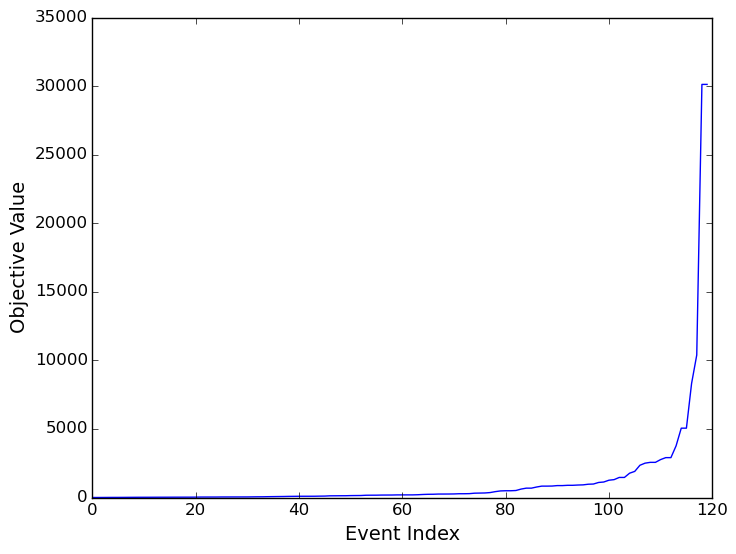

In [35]:
plot(sort(score[score.<Inf]))
xlabel("Event Index",fontsize=14)
ylabel("Objective Value",fontsize=14)
#ylim([0,600])

#savefig("../images/scores.pdf")

In [4]:
@time(loop_through_lines(
    G_of_x,Q_of_x,A1,b,
n,T,tau,Ridx,ref,lines))

println("solved")

elapsed time: 67.819097441 seconds (14913261356 bytes allocated, 16.59% gc time)
solved


In [9]:
indmin(score)

62

In [31]:
@manipulate for c = 0.01:0.01:0.5
    kQtheta = -c
    Q_of_x = (Qtheta,0,kQtheta)
    score,x,θ,α,diffs = loop_through_lines(
        G_of_x,Q_of_x,A1,b,
        n,T,tau,Ridx,ref,lines[118:118])
    #max_dev = maximum(abs([x[1][1],x[1][2],x[1][3]]))
    sort(P0[find(P0)] + [x[1][1],x[1][2],x[1][3]])
end

Slider{Float64}([Input{Float64}] 0.25,"c",0.25,0.01:0.01:0.5)

54-element Array{Float64,1}:
 -1.17682  
 -0.783641 
 -0.730216 
 -0.202558 
 -0.0557215
  0.0194977
  0.0287793
  0.0425899
  0.0535853
  0.0635791
  0.0654565
  0.0685002
  0.0767611
  ⋮        
  0.741274 
  0.770436 
  0.815073 
  0.850682 
  0.88424  
  1.00853  
  1.0641   
  1.31623  
  1.32228  
  1.67815  
  1.93312  
  2.27311  

In [15]:
score,x,θ,α,diffs,xopt = loop_through_lines(
    G_of_x,Q_of_x,A1,b,
    n,T,tau,Ridx,ref,lines[91:91])

([1.04144],Array[[[0.107471,0.107015,0.106329,0.105853,0.105632,0.106888,0.107374,0.105426,0.107641,0.11,0.110454,0.110482,0.110209,0.110789,0.111108,0.0266084,-0.133353,0.340219],[0.113646,0.113164,0.112438,0.111935,0.111701,0.113029,0.113543,0.111483,0.113826,0.11632,0.1168,0.11683,0.116541,0.117154,0.117492,0.0281372,-0.141015,0.359767],[0.119821,0.119313,0.118548,0.118017,0.11777,0.119171,0.119712,0.117541,0.12001,0.12264,0.123147,0.123178,0.122873,0.12352,0.123875,0.029666,-0.148677,0.379315]]],Array[[[4.59341e-15,-0.00107658,0.0775653,-0.00188153,-0.0125036,-0.029847,-0.0960397,-0.0934279,0.0477475,0.0154665  …  0.223223,0.276235,0.292523,0.229063,0.257947,0.302367,0.368164,0.283038,0.137735,0.292557],[3.38409e-15,-0.000977484,0.0873015,0.000521243,-0.011252,-0.02789,-0.106939,-0.100624,0.0520368,0.0180137  …  0.204827,0.25659,0.272663,0.214336,0.24641,0.281677,0.34508,0.273257,0.119507,0.285629],[-1.94781e-16,-0.00087839,0.0970378,0.00292402,-0.0100005,-0.025933,-0.117839,-0.107

In [12]:
xopt[1]

279-element Array{Float64,1}:
 -0.0800592  
 -4.78327e-5 
  0.00193417 
  0.00220607 
  0.0023327  
  0.00109959 
  0.00037386 
  0.0024503  
 -2.52897e-5 
 -0.000612555
 -0.000402802
 -0.000374328
 -0.000335747
  ⋮          
  4.84937    
  4.79788    
  4.78521    
  4.89891    
  5.00247    
  4.78745    
  4.83751    
  4.72492    
 -3.49837    
  0.0011627  
  0.00237283 
  0.316217   

In [30]:
x[118][1]

18-element Array{Float64,1}:
  0.0263829  
  0.0296135  
  0.0344819  
  0.037857   
  0.0394291  
  0.0305182  
  0.0270715  
  0.0408888  
  0.0251758  
  0.00844346 
  0.00521972 
  0.00502096 
  0.00696014 
  0.0028454  
  0.000582288
 -0.0430148  
 -0.0437667  
 -0.0434666  

In [26]:
indmax(abs([x[1][1],x[1][2],x[1][3]]))

54

In [29]:
maximum(P0[find(P0)])

1.2290921062231064

In [20]:
θ[1][2][56] - θ[1][2][57]

-0.1653004242402364

In [4]:
lines[91]

(56,57)

In [29]:
# find event index of i-th event:
find(score.==sort(score[score.<Inf])[3])

1-element Array{Int64,1}:
 118

In [37]:
α[118]

3-element Array{Float64,1}:
 -36.5117
 -39.0616
 -42.9235

## An interesting case

What if the wind forecast increases significantly over the course of a few time steps?

What can this model do that others can't? It can track changes _in time_. In order to be interesting, results must include significant changes in dispatch, demand, or forecast.

What if forecast increases but demand decreases? What if forecast peaks sharply in the last time step?